# HK Model with Separable Landau Interaction

## 1. Setup 1D ($\mu(\rho)$)

In [1]:
import numpy as np
from scipy.optimize import root, minimize, root_scalar
import matplotlib.pyplot as plt

t = 1
d = 1

def I_1(vars):
    x, y = vars
    if np.abs(x / (2 * t * y)) < 1:
        return np.heaviside(x + 2 * t * y, 1) - np.arccos(x / (2 * t * y)) / np.pi
    else:
        return np.heaviside(x + 2 * t * y, 1)
    
def J_1(vars):
    x, y = vars
    if np.abs(x / (2 * t * y)) < 1:
        return - np.sqrt((2 * t * y)**2 - x**2) / np.pi
    else:
        return 0

# Only for U > 0!   
def GLS_1d(vars):
    rho, mu, U, e_tilde, f_0, f_1 = vars
    eq1 = rho - (I_1([mu - f_0 * rho, 1 + f_1 * e_tilde]) + I_1([mu - U - f_0 * rho, 1 + f_1 * e_tilde]))
    eq2 = e_tilde - (J_1([mu - f_0 * rho, 1 + f_1 * e_tilde]) + J_1([mu - U - f_0 * rho, 1 + f_1 * e_tilde]))
    return [eq1, eq2]

def solve_GLS_1d_for_mu(rho, U, f_0, f_1, initial_guess):
    # def x = [mu, e_tilde]
    GLS_reduced = lambda x: GLS_1d([rho, x[0], U, x[1], f_0, f_1])
    sol = root(GLS_reduced, initial_guess, method='hybr')
    # Should return list [mu, e_tilde] for any given rho
    return sol.x

def make_solution_arrays_mu_e(rho_array, U, f_0, f_1):
    mu_list = []
    e_tilde_list = []

    for rho_val in rho_array:
        if U <= 4 * t * d:
            # Model as one straight line through start and endpoint
            guess_rho = (U / 2 + 2) * rho_val - 2
        else:
            # Model as two different lines for each band
            if rho_val <= 1:
                guess_rho = 4 * rho_val - 2
            else:
                guess_rho = 4 * rho_val + U - 6

        a = 1

        if U <= 4 * t * d:
            # Model as a(x**2 - 2x)
            guess_e = a * (rho_val**2 - 2 * rho_val)
        else:
            # Model as two different parabolas for each band
            if rho_val <= 1:
                guess_e = a * (rho_val**2 - rho_val)
            else:
                guess_e = a * (rho_val**2 - 3 * rho_val + 2)


        guess = [guess_rho, guess_e]

        sol = solve_GLS_1d_for_mu(rho_val, U, f_0, f_1, guess)
        mu_list.append(sol[0])
        e_tilde_list.append(sol[1])

    mu_array = np.array(mu_list)
    e_tilde_array = np.array(e_tilde_list)

    return mu_array, e_tilde_array

def minimize_GLS_norm_1d_wrt_rho_w_guess(rho, U, f_0, f_1, initial_guess):
    # def x = [mu, e_tilde]
    GLS_reduced = lambda x: GLS_1d([rho, x[0], U, x[1], f_0, f_1])
    GLS_reduced_norm = lambda x: GLS_reduced(x)[0]**2 + GLS_reduced(x)[1]**2

    sol = minimize(GLS_reduced_norm, initial_guess, method='L-BFGS-B')
    # Should return list [mu, e_tilde] for any given rho
    return sol.x

def make_solution_arrays_norm_mu_e(rho_array, U, f_0, f_1):
    mu_list = []
    e_tilde_list = []

    for rho_val in rho_array:
        if U <= 4 * t * d:
            # Model as one straight line through start and endpoint
            guess_rho = (U / 2 + 2) * rho_val - 2
        else:
            # Model as two different lines for each band
            if rho_val <= 1:
                guess_rho = 4 * rho_val - 2
            else:
                guess_rho = 4 * rho_val + U - 6

        a = 1

        if U <= 4 * t * d:
            # Model as a(x**2 - 2x)
            guess_e = a * (rho_val**2 - 2 * rho_val)
        else:
            # Model as two different parabolas for each band
            if rho_val <= 1:
                guess_e = a * (rho_val**2 - rho_val)
            else:
                guess_e = a * (rho_val**2 - 3 * rho_val + 2)


        guess = [guess_rho, guess_e]

        sol = minimize_GLS_norm_1d_wrt_rho_w_guess(rho_val, U, f_0, f_1, guess)
        mu_list.append(sol[0])
        e_tilde_list.append(sol[1])

    mu_array = np.array(mu_list)
    e_tilde_array = np.array(e_tilde_list)

    return mu_array, e_tilde_array


def one_plot(x_array, y_array, x_label, y_label, title):
    plt.figure(dpi=100)
    # Plot erstellen
    plt.plot(x_array, y_array, linestyle='-')
    
    # Achsenbeschriftungen und Titel
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show() 

def many_plots(U_array, x_arrays, y_arrays, xlabel, ylabel, title):
    plt.figure(dpi=150)
    # Plot erstellen
    for i in range(len(x_arrays)):
        plt.plot(x_arrays[i], y_arrays[i], linestyle='-', label=f'U = {U_array[i]}')
    
    # Achsenbeschriftungen und Titel
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

Idea: Dont take rho array as given, but mu array. compute rho(mu). As this should not have points where the derivative is near zero, newton-techniques will likely be more succesfull and we can get rid of kinks in numerical calculations. Try to findout if wrinkle for rho=1, U=4 is numerical error or actual physics, i.e. has $U_c(\rho = 1) = W$ shifted?

## 1.1 Setup for $\rho(\mu)$

In [51]:
def solve_GLS_1d_for_rho(mu, U, f_0, f_1, initial_guess):
    # def x = [rho, e_tilde]
    GLS_reduced = lambda x: GLS_1d([x[0], mu, U, x[1], f_0, f_1])
    sol = root(GLS_reduced, initial_guess, method='hybr')
    # Should return list [rho, e_tilde] for any given mu
    return sol.x

def make_solution_arrays_rho_e(mu_array, U, f_0, f_1):
    rho_list = []
    e_tilde_list = []

    for mu_val in mu_array:
        if U <= 4 * t * d:
            # Model as one straight line through start and endpoint
            guess_rho = (2 / (4 * t + U)) * mu_val + 4 * t / (4 * t + U)
        else:
            # Model as two different lines for each band
            if mu_val <= 2 * t:
                guess_rho = mu_val / (4 * t) + 1 / (2 * t)
            elif 2 * t < mu_val <= U - 2 * t:
                guess_rho = 1
            elif U - 2 * t < mu_val:
                guess_rho = mu_val / (4 * t) + (3 - U / (2 * t)) / 2


        if U <= 4 * t * d:
            a = 1
            b = - a * (4 * t + U**2) / (4 * t + U)
            c = 2 * t * b - 4 * t**2 * a
            # Model as ax**2 + bx + c
            guess_e = a * mu_val**2 + b * mu_val + c
        else:
            a = 0.5
            # Model as two different parabolas for each band
            if mu_val <= 2 * t:
                guess_e = a * (mu_val**2 - 4 * t**2 * a)
            elif 2 * t < mu_val <= U - 2 * t:
                guess_e = 0
            elif U - 2 * t < mu_val:
                b = - a *  (4 * t * U) / (U + 2 * t)
                c = - (U**2 + 2 * t**2) * a - U * b
                guess_e = a * mu_val**2 + b * mu_val + c


        guess = [guess_rho, 0]

        sol = solve_GLS_1d_for_rho(mu_val, U, f_0, f_1, guess)
        rho_list.append(sol[0])
        e_tilde_list.append(sol[1])

    rho_array = np.array(rho_list)
    e_tilde_array = np.array(e_tilde_list)

    return rho_array, e_tilde_array

def minimize_GLS_norm_1d_rho_e(mu, U, f_0, f_1, initial_guess):
    # def x = [rho, e_tilde]
    GLS_reduced = lambda x: GLS_1d([x[0], mu, U, x[1], f_0, f_1])
    GLS_reduced_norm = lambda x: GLS_reduced(x)[0]**2 + GLS_reduced(x)[1]**2

    sol = minimize(GLS_reduced_norm, initial_guess, method='L-BFGS-B')
    # Should return list [rho, e_tilde] for any given rho
    return sol.x

def make_solution_arrays_norm_rho_e(mu_array, U, f_0, f_1):
    rho_list = []
    e_tilde_list = []

    for mu_val in mu_array:
        if U <= 4 * t * d:
            # Model as one straight line through start and endpoint
            guess_rho = (2 / (4 * t + U)) * mu_val + 4 * t / (4 * t + U)
        else:
            # Model as two different lines for each band
            if mu_val <= 2 * t:
                guess_rho = mu_val / (4 * t) + 1 / (2 * t)
            elif 2 * t < mu_val <= U - 2 * t:
                guess_rho = 1
            elif U - 2 * t < mu_val:
                guess_rho = mu_val / (4 * t) + (3 - U / (2 * t)) / 2


        if U <= 4 * t * d:
            a = 1
            b = - a * (4 * t + U**2) / (4 * t + U)
            c = 2 * t * b - 4 * t**2 * a
            # Model as ax**2 + bx + c
            guess_e = a * mu_val**2 + b * mu_val + c
        else:
            a = 0.5
            # Model as two different parabolas for each band
            if mu_val <= 2 * t:
                guess_e = a * (mu_val**2 - 4 * t**2 * a)
            elif 2 * t < mu_val <= U - 2 * t:
                guess_e = 0
            elif U - 2 * t < mu_val:
                b = - a *  (4 * t * U) / (U + 2 * t)
                c = - (U**2 + 2 * t**2) * a - U * b
                guess_e = a * mu_val**2 + b * mu_val + c


        guess = [guess_rho, 0]

        sol = minimize_GLS_norm_1d_rho_e(mu_val, U, f_0, f_1, guess)
        rho_list.append(sol[0])
        e_tilde_list.append(sol[1])

    rho_array = np.array(rho_list)
    e_tilde_array = np.array(e_tilde_list)

    return rho_array, e_tilde_array

In [ ]:
U_re = 5

mu_array_re = np.linspace(-2 * t, 2 * t + U_re, 1000)
rho_array_re, e_array_re = make_solution_arrays_norm_rho_e(mu_array_re, U_re, 0, 0)
rho_array_re_f0, e_array_re_f0 = make_solution_arrays_norm_rho_e(mu_array_re, U_re, 0, 0.5)
one_plot(rho_array_re[1:], mu_array_re[1:], r'$\rho$', r'$\mu$', r'$f_0 = 0$')
one_plot(rho_array_re_f0[1:], mu_array_re[1:], r'$\rho$', r'$\mu$', r'$f_0 = 0.5$')

one_plot(mu_array_re, e_array_re, r'$\mu$', r'$e$', r'$f_1 = 0$')
one_plot(rho_array_re_f0, e_array_re_f0, r'$\rho$', r'$e$', r'$f_1 = 0.5$')

Note that e is 0 for rho = 1, this means that Mott-inulating phase is not affected at all by this interaction! Note also that this is the case for rho=0 and rho=2, yet the compressibility seems to also be renormalized?

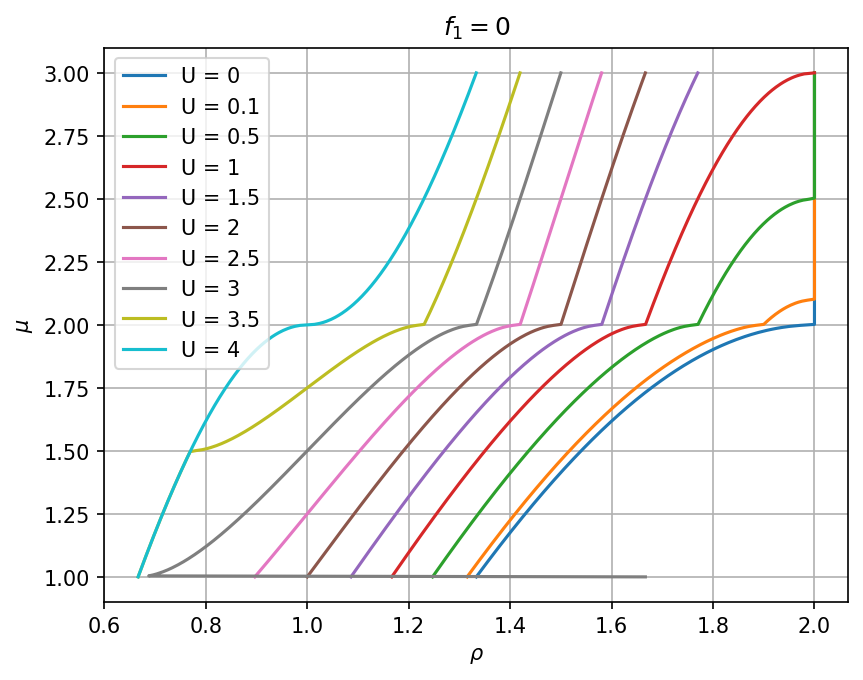

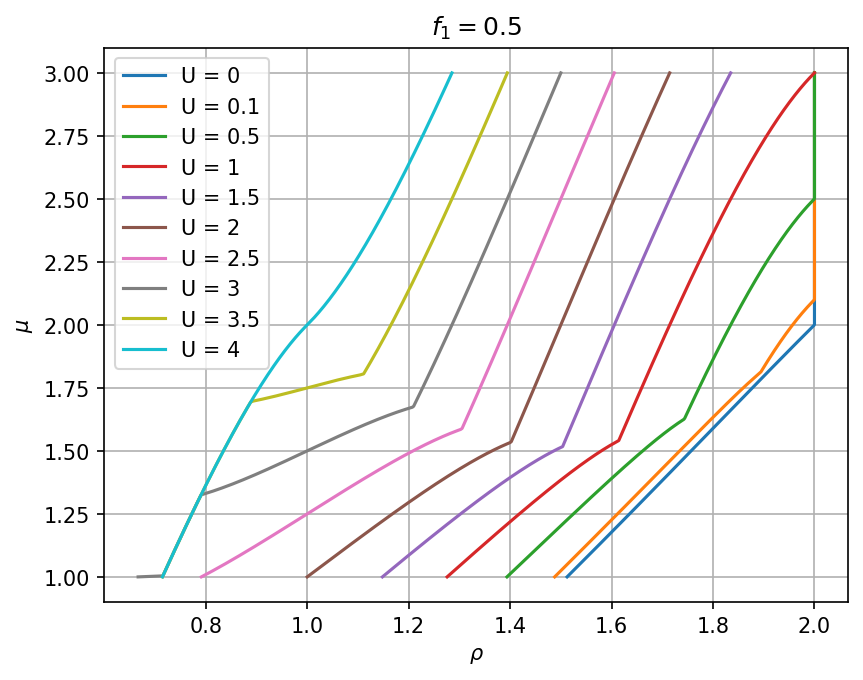

In [59]:
U_values = [0, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
mu_arrays = []
rho_arrays_U_values_hk = []
rho_arrays_U_values_f1_05 = []

for U_val in U_values:
    mu_arr = np.linspace(1, 3, 500)
    mu_arrays.append(mu_arr)
    rho_arr, e_arr = make_solution_arrays_rho_e(mu_arr, U_val, 0, 0)
    rho_arrays_U_values_hk.append(rho_arr)

ctr = 0

for U_val in U_values:
    rho_arr, e_arr = make_solution_arrays_rho_e(mu_arrays[ctr], U_val, 0, 0.5)
    rho_arrays_U_values_f1_05.append(rho_arr)
    ctr += 1

many_plots(U_values, rho_arrays_U_values_hk, mu_arrays, r'$\rho$', r'$\mu$', r'$f_1 = 0$')
many_plots(U_values, rho_arrays_U_values_f1_05, mu_arrays, r'$\rho$', r'$\mu$', r'$f_1 = 0.5$')

Phase Transition no longer at constant mu, however it seems to mirror the behavior of e, as in phase transition is a parabola with minimum -0.5 from roots (here 2)

## 2. Phase Diagram

In [36]:
def minimize_GLS_norm_1d_wrt_rho(rho, U, f_0, f_1):
    a = 1
    guess_rho = (U / 2 + 2) * rho - 2
    guess_e = a * (rho**2 - 2 * rho)
    guess = [guess_rho, guess_e]

    # def x = [mu, e_tilde]
    GLS_reduced = lambda x: GLS_1d([rho, x[0], U, x[1], f_0, f_1])
    GLS_reduced_norm = lambda x: GLS_reduced(x)[0]**2 + GLS_reduced(x)[1]**2

    sol = minimize(GLS_reduced_norm, guess, method='L-BFGS-B')
    # Should return list [mu, e_tilde] for any given rho
    return sol.x

def find_U_c_of_rho(rho, f_0, f_1):
    if rho <= 1:
        def func_U(U):
            mu, e = minimize_GLS_norm_1d_wrt_rho(rho, U, f_0, f_1)
            return mu + 2 * t * (1 + f_1 * e) - U
        result = root_scalar(func_U, x0=4*rho, method='newton', xtol=1e-3)
    elif rho > 1:
        def func_U(U):
            mu, e = minimize_GLS_norm_1d_wrt_rho(rho, U, f_0, f_1)
            return mu - 2 * t * (1 + f_1 * e)
        result = root_scalar(func_U, x0=(8-4*t*d*rho), method='newton', xtol=1e-3)

    if result.converged:
        return result.root
    else:
        print(result.flag)
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")
    
def create_U_c_array(rho_array, f_0, f_1):
    U_c_list = []

    for rho_i in rho_array:
        print(f'\rProgress: {(rho_i/2 * 100):.1f}%{' ' * 20}', end="", flush=True)
        try:
            U_i = find_U_c_of_rho(rho_i, f_0, f_1)
            U_c_list.append(U_i)
        except RuntimeError:
            U_c_list.append(np.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")

    U_c_array = np.array(U_c_list)

    return U_c_array

In [ ]:
rho_array_Uc = np.linspace(0, 2, 201)
Uc_array_05 = create_U_c_array(rho_array_Uc, 0, 0.5)

Progress: 0.0%                    

Progress: 100.0%                    

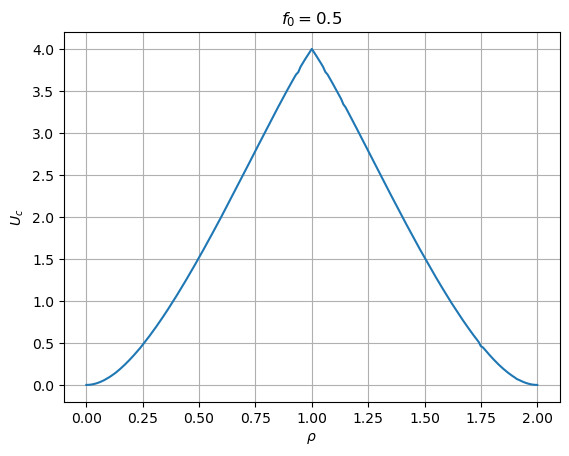

In [ ]:
one_plot(rho_array_Uc, Uc_array_05, r'$\rho$', r'$U_c$', r'$f_0=0.5$')

Progress: 100.0%                    

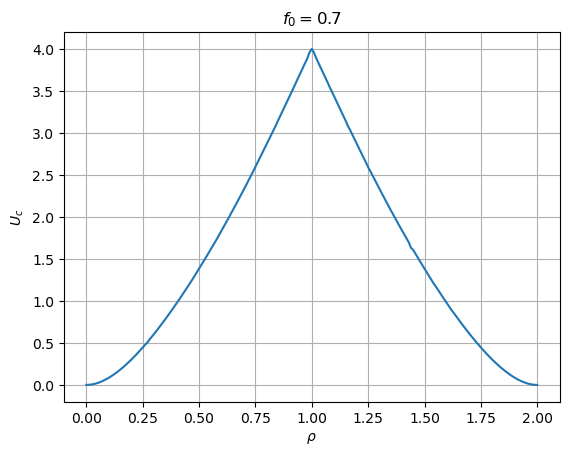

In [45]:
Uc_array_07 = create_U_c_array(rho_array_Uc, 0, 0.7)
one_plot(rho_array_Uc, Uc_array_07, r'$\rho$', r'$U_c$', r'$f_0=0.7$')

Progress: 1.0%                    convergence error
Keine Nullstelle gefunden für rho=0.02
Progress: 100.0%                    

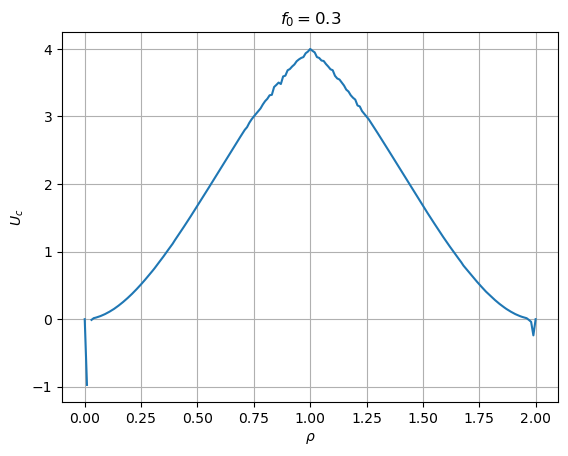

In [49]:
Uc_array_01 = create_U_c_array(rho_array_Uc, 0, 0.3)
one_plot(rho_array_Uc, Uc_array_01, r'$\rho$', r'$U_c$', r'$f_0=0.3$')